In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd 

In [3]:
import seaborn as sns
from collections import Counter
import os
import torch
import torch.nn as nn
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from torch.optim import lr_scheduler

from PIL import Image

import sys
import torch.optim as optim

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, classification_report, ConfusionMatrixDisplay


In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [22]:
# Dataset manipulation
train_val_folder = 'dataverse_files/HAM10000_images_pca_augmented_3_resnet'
test_folder = 'dataverse_files/ISIC2018_Task3_Test_Images_resnet'
csv_train = 'dataverse_files/HAM10000_metadata_augmented_3_train.csv'
csv_val = 'dataverse_files/HAM10000_metadata_augmented_3_val.csv'
csv_test = 'dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv'

class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = f'{self.image_folder}/{self.data.iloc[idx, 0]}'
        image = Image.open(img_name).convert('RGB')

        label = int(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create instances of custom datasets
train_dataset = CustomDataset(csv_file=csv_train, image_folder=train_val_folder, transform=transform)
val_dataset = CustomDataset(csv_file=csv_val, image_folder=train_val_folder, transform=transform)
test_dataset = CustomDataset(csv_file=csv_test, image_folder=test_folder, transform=transform)

# You can create DataLoader instances for each dataset
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset sizes
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 5178
Validation dataset size: 370
Test dataset size: 1512


In [7]:
# Dataset manipulation
train_val_folder = 'dataverse_files/HAM10000_images_pca_augmented_3_resnet'
test_folder = 'dataverse_files/ISIC2018_Task3_Test_Images_resnet'
csv_train = 'dataverse_files/HAM10000_metadata_augmented_3_train.csv'
csv_val = 'dataverse_files/HAM10000_metadata_augmented_3_val.csv'
csv_test = 'dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv'

# Convert dataset to PyTorch Dataset
class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        y_label = torch.tensor(self.class_to_idx[self.annotations.iloc[index, 1]])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

# Convert now
train_dataset = HAM10000Dataset(csv_file=csv_train, root_dir=train_val_folder)
val_dataset = HAM10000Dataset(csv_file=csv_val, root_dir=train_val_folder)
test_dataset = HAM10000Dataset(csv_file=csv_test, root_dir=test_folder)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 3):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [9]:
train_dataloader = DataLoader(dataset=train_dataset,batch_size=64,shuffle=True,num_workers=4)
val_dataloader = DataLoader(dataset=val_dataset,batch_size=64,shuffle=True,num_workers=4)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=64,shuffle=True,num_workers=4)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [12]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [13]:
def _make_layer(block, inplanes,planes, blocks, stride=1):
    downsample = None  
    if stride != 1 or inplanes != planes:
        downsample = nn.Sequential(            
            nn.Conv2d(inplanes, planes, 1, stride, bias=False),
            nn.BatchNorm2d(planes),
        )
    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))
    return nn.Sequential(*layers)

In [14]:
layers=[3, 4, 6, 3]

In [15]:
layer1 =_make_layer(BasicBlock, inplanes=64,planes=64, blocks=layers[0])
layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

In [16]:
layer2 = _make_layer(BasicBlock, 64, 128, layers[1], stride=2)
layer2

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

In [17]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=3):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x

In [18]:
model = ResNet(block = BasicBlock, layers = layers).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [19]:
#n_epochs=1

for epoch in range(1,5):
    running_loss = 0.0
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % 20 == 19:    
                
                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1,running_loss/20))
        
        running_loss = 0.0
     
    

print('\nFinished Training')

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/mehmet/miniforge3/envs/ml-torch/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/mehmet/miniforge3/envs/ml-torch/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'HAM10000Dataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [43]:
with torch.no_grad():
    ground_truth = []
    prediction = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        ground_truth.append(labels.cpu().tolist())
        prediction.append(predicted.cpu().tolist())

In [55]:
report = classification_report(ground_truth, prediction, target_names = ['with_mask', 'without_mask', 'mask_weared_incorrect'])
print(report)

                       precision    recall  f1-score   support

            with_mask       0.94      0.97      0.95       953
         without_mask       0.83      0.85      0.84       235
mask_weared_incorrect       0.00      0.00      0.00        34

             accuracy                           0.92      1222
            macro avg       0.59      0.61      0.60      1222
         weighted avg       0.89      0.92      0.90      1222



/Users/mehmet/anaconda3/envs/cs464/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehmet/anaconda3/envs/cs464/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehmet/anaconda3/envs/cs464/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

[[921  32   0]
 [ 35 200   0]
 [ 26   8   0]]
Accuracy: 91.73%
Recall: 60.58%
Precision: 59.04%
F1 Score: 59.80%


/Users/mehmet/anaconda3/envs/cs464/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

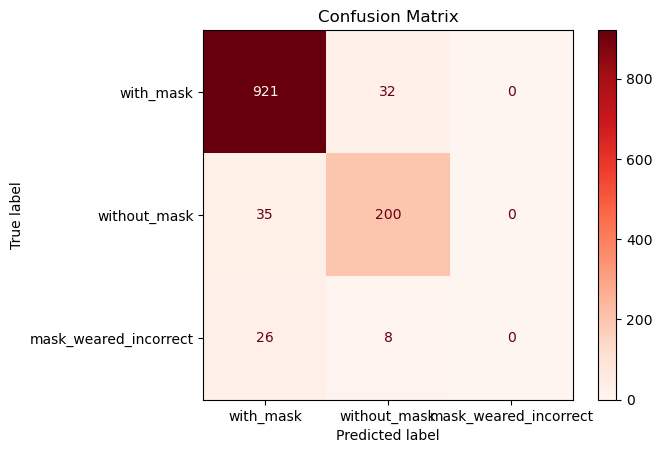

In [52]:
#ground_truth = [j for sub in ground_truth for j in sub]
#prediction = [j for sub in prediction for j in sub]
cm = confusion_matrix(ground_truth, prediction)
ac = accuracy_score(ground_truth, prediction)
f1 = f1_score(ground_truth, prediction, average='macro')
precision = precision_score(ground_truth, prediction, average='macro')
recall = recall_score(ground_truth, prediction, average='macro')

print(cm)
print(f'Accuracy: {100 * ac:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['with_mask', 'without_mask', 'mask_weared_incorrect']
                              )
disp.plot(cmap='Reds')
disp.ax_.set_title('Confusion Matrix')